In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("~/lens_calibration/liquid_lens_calibration.csv")

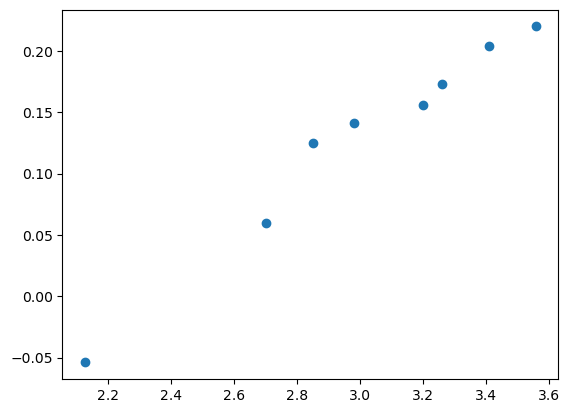

In [4]:
fig = plt.figure()
plt.plot(df["dpt"], df["distance"], "o")
plt.show()

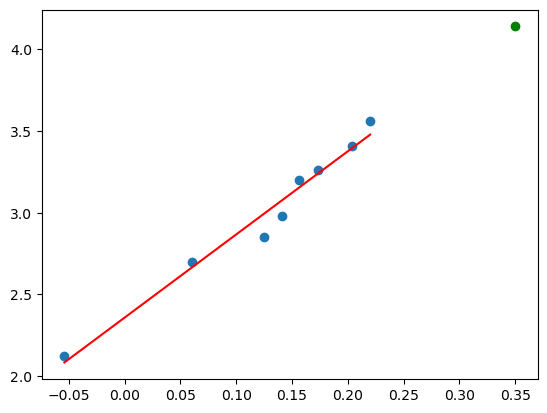

In [5]:
# use linear regression to predit dpt from distance
from sklearn.linear_model import LinearRegression

X = df["distance"].values.reshape(-1, 1)
y = df["dpt"].values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
fig = plt.figure()
plt.scatter(X, y)
plt.plot(X, y_pred, color="red")

x_out = 0.35
y_out = model.predict([[x_out]])

plt.scatter(x_out, y_out, color="green")
plt.show()